In [1]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
START_DT = '2018-09-01'
END_DT = '2019-09-05'

In [0]:
dts = pd.date_range(START_DT, END_DT, freq='D')

In [0]:
TIME_LEN = len(dts)

In [5]:
TIME_LEN

370

In [0]:
PERIOD1 = 50  # day
PERIOD2 = 30  # day
F1 = 1 / PERIOD1
F2 = 1 / PERIOD2

In [0]:
feat1 = np.sin(2.0 * np.pi * F2 * np.arange(TIME_LEN)) \
        + np.cos(2.0 * np.pi * F1 *  np.arange(TIME_LEN)) \
        + 0.005*np.arange(TIME_LEN) \
        + 0.2*np.random.randn(TIME_LEN)

In [0]:
feat_scaler = MinMaxScaler((0, 0.1))

In [0]:
feat1 = feat_scaler.fit_transform(feat1.reshape(-1, 1)).flatten()

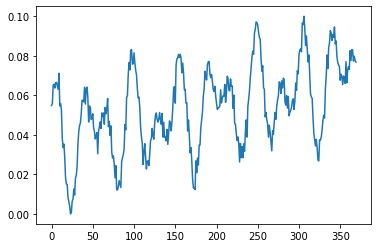

In [10]:
plt.plot(feat1)

In [0]:
y = 0.6 * feat1 + 0.2 * feat1.max() * np.sin(0.2 * np.arange(TIME_LEN)) + 0.05*feat1.max() *np.random.randn(TIME_LEN)
# y *= 100

In [0]:
y_scaler = MinMaxScaler((0, 0.1))

In [0]:
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

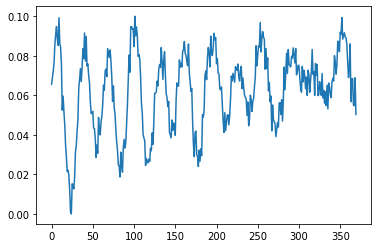

In [14]:
plt.plot(y)

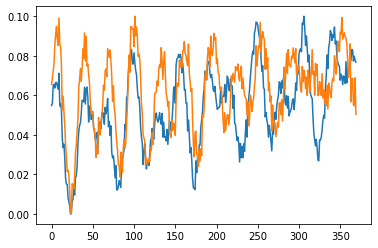

In [15]:
plt.plot(feat1)
plt.plot(y)

In [0]:
df = pd.DataFrame({
    'datetime': dts,
    'y': y,
    'feat1': feat1
})

In [0]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [0]:
df.set_index('datetime', inplace=True)

In [0]:
df['feat1_smooth'] = df['feat1'].rolling(10).mean()

In [0]:
df['y_smooth'] = df['y'].rolling(10).mean()

In [0]:
df.dropna(how='any', inplace=True)

In [0]:
ALPHA_D = 20

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.feat1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

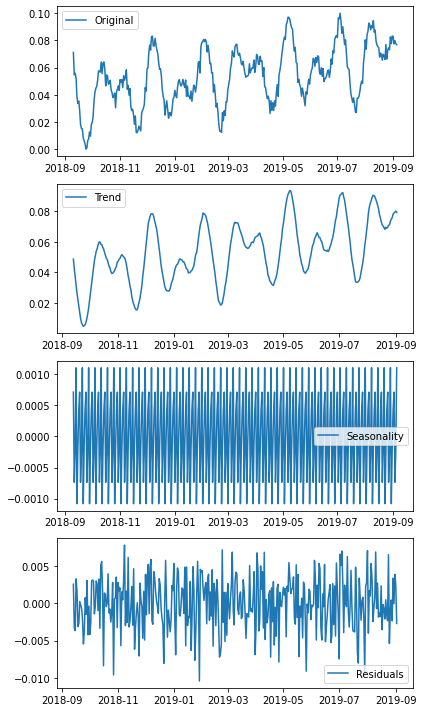

In [24]:
plt.figure(figsize=(6, 10))

# オリジナルの時系列データプロット
plt.subplot(411)
plt.plot(df.feat1, label='Original')
plt.legend(loc='best')

# trend のプロット
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# seasonal のプロット
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

# residual のプロット
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
df_train = df[df.index <= '2019-06']
df_test = df[df.index > '2019-06']

In [37]:
sm.tsa.arma_order_select_ic(df_train.feat1_smooth, ic='aic', trend='nc')

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsa

{'aic':              0            1            2
 0          NaN -1170.120507 -1501.899652
 1 -2359.903226 -2596.252282 -2744.884542
 2 -2962.362930 -2960.621350 -2978.070012
 3 -2960.797249 -3016.212719 -3118.705910
 4 -1458.004818 -3058.729351 -3115.714961, 'aic_min_order': (3, 2)}

In [44]:
SARIMA_3_1_2 = sm.tsa.SARIMAX(
    df_train.feat1_smooth, order=(3, 1, 2),
    seasonal_order=(1, 1, 1, 30),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(method='bfgs')#, maxiter=3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


         Current function value: -4.536305
         Iterations: 27
         Function evaluations: 117
         Gradient evaluations: 105


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


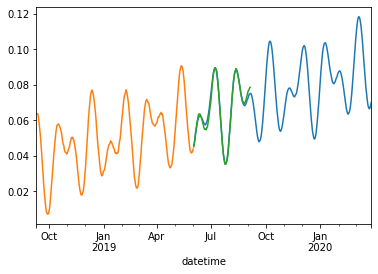

In [45]:
SARIMA_3_1_2.forecast(steps=300).plot()
df_train.feat1_smooth.plot()
df_test.feat1_smooth.plot()

In [0]:
# order(p, d, q)
min_p = 1; max_p = 3
min_d = 0; max_d = 1
min_q = 0; max_q = 3 

# seasonal_order(sp, sd, sq)
min_sp = 0; max_sp = 1
min_sd = 0; max_sd = 1
min_sq = 0; max_sq = 1

In [50]:
import warnings
warnings.filterwarnings('ignore')

ps = []
ds = []
qs = []
sps = []
sds = []
sqs = []
aics = []

for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            df_train.feat1_smooth,
                            order=(p, d, q), 
                            seasonal_order=(sp, sd, sq, PERIOD2), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        ps.append(p)
                        ds.append(d)
                        qs.append(q)
                        sps.append(sp)
                        sds.append(sd)
                        sqs.append(sq)
                        aics.append(sarima.aic)
                        print(f'{p}, {d}, {q} : {sp}, {sd}, {sq} : {sarima.aic}')

1, 0, 0 : 0, 0, 0 : -2357.532463892491
1, 0, 0 : 0, 0, 1 : -2122.120021274972
1, 0, 0 : 0, 1, 0 : -2062.877316124722
1, 0, 0 : 0, 1, 1 : -1681.0700563746425
1, 0, 0 : 1, 0, 0 : -2146.475983135001
1, 0, 0 : 1, 0, 1 : -2127.6880557343115
1, 0, 0 : 1, 1, 0 : -1526.0645965674462
1, 0, 0 : 1, 1, 1 : -1927.3900414155703
1, 0, 1 : 0, 0, 0 : -2571.5123750368066
1, 0, 1 : 0, 0, 1 : -2296.7896204637054
1, 0, 1 : 0, 1, 0 : -2223.2731653319124
1, 0, 1 : 0, 1, 1 : -1824.0585918529005
1, 0, 1 : 1, 0, 0 : -2235.445394640251
1, 0, 1 : 1, 0, 1 : -2378.9134527402084
1, 0, 1 : 1, 1, 0 : -2113.9223584610413
1, 0, 1 : 1, 1, 1 : -2042.9580906813371
1, 0, 2 : 0, 0, 0 : -2694.0250137468856
1, 0, 2 : 0, 0, 1 : -2309.2038351452447
1, 0, 2 : 0, 1, 0 : -2186.6447335590806
1, 0, 2 : 0, 1, 1 : -1790.729262275715
1, 0, 2 : 1, 0, 0 : -2198.167666029697
1, 0, 2 : 1, 0, 1 : -1853.1893867445724
1, 0, 2 : 1, 1, 0 : -2104.9912282726737
1, 0, 2 : 1, 1, 1 : -2019.0836774446389
1, 0, 3 : 0, 0, 0 : -2735.940402888053
1, 0, 3 

In [0]:
df_aics = pd.DataFrame({
    'p': ps,
    'd': ds,
    'q': qs,
    'sp': sps,
    'sd': sds,
    'sq': sqs,
    'aic': aics
})

In [54]:
df_aics.dropna().sort_values(by='aic')

,p,d,q,sp,sd,sq,aic
184,3,1,3,0,0,0,-3030.268135
112,2,1,2,0,0,0,-3008.004613
144,3,0,2,0,0,0,-2989.958323
80,2,0,2,0,0,0,-2952.773702
56,1,1,3,0,0,0,-2952.530011
...,...,...,...,...,...,...,...
6,1,0,0,1,1,0,-1526.064597
104,2,1,1,0,0,0,-1283.842005
109,2,1,1,1,0,1,-1152.884796
108,2,1,1,1,0,0,-1148.231034


In [66]:
SARIMA_3_1_3_0_0_0 = sm.tsa.SARIMAX(
    df_train.feat1_smooth, order=(3, 1, 3),
    seasonal_order=(0, 0, 0, 30),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(method='bfgs')#, maxiter=3)

         Current function value: -5.820956
         Iterations: 26
         Function evaluations: 82
         Gradient evaluations: 71


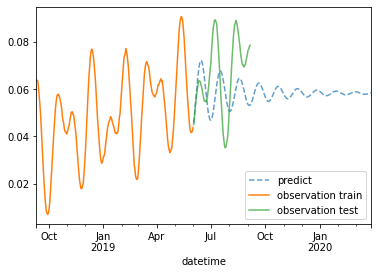

In [68]:
SARIMA_3_1_3_0_0_0.forecast(steps=300).plot(linestyle='dashed', alpha=0.7, label='predict')
df_train.feat1_smooth.plot(label='observation train')
df_test.feat1_smooth.plot(alpha=0.7, label='observation test')
plt.legend()

In [69]:
SARIMA_3_1_3_1_1_1 = sm.tsa.SARIMAX(
    df_train.feat1_smooth, order=(3, 1, 3),
    seasonal_order=(1, 1, 1, 30),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(method='bfgs')#, maxiter=3)

         Current function value: -4.515240
         Iterations: 28
         Function evaluations: 134
         Gradient evaluations: 113


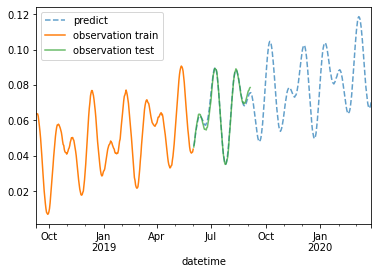

In [70]:
SARIMA_3_1_3_1_1_1.forecast(steps=300).plot(linestyle='dashed', alpha=0.7, label='predict')
df_train.feat1_smooth.plot(label='observation train')
df_test.feat1_smooth.plot(alpha=0.7, label='observation test')
plt.legend()

In [0]:
resid = SARIMA_3_1_3_1_1_1.resid

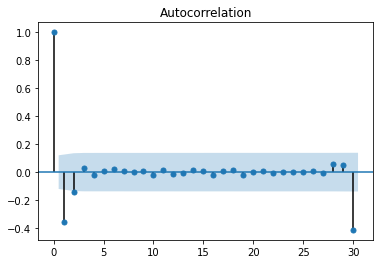

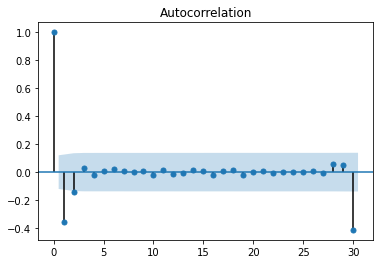

In [72]:
sm.graphics.tsa.plot_acf(resid, lags=PERIOD2)

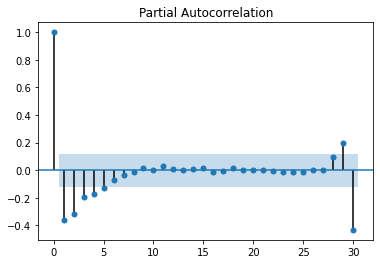

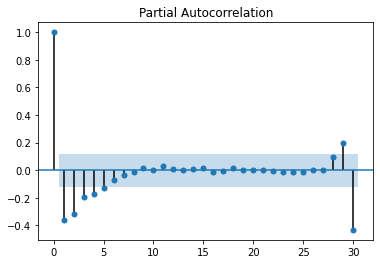

In [73]:
sm.graphics.tsa.plot_pacf(resid, lags=PERIOD2)